## Multi-label classification with Keras

In [0]:
!ls -l

total 696
-rw-rw-r-- 1 tcs tcs 698987 Sep 20 14:28 damage_analyzer_model.ipynb
drwxrwxr-x 9 tcs tcs   4096 Sep 20 10:13 Dataset
drwxrwxr-x 4 tcs tcs   4096 Sep 15 09:08 fastai
drwxr-xr-x 4 tcs tcs   4096 Sep 20 14:32 tf_serving


In [0]:
!tree -d

.
├── Dataset
│   ├── building_minor
│   ├── building_moderate
│   ├── building_severe
│   ├── vehicle_minor
│   ├── vehicle_moderate
│   ├── vehicle_nodamage
│   └── vehicle_severe
├── fastai
│   ├── lesson1
│   └── lesson2
│       └── keras-multi-label
│           ├── dataset
│           │   ├── black_jeans
│           │   ├── blue_dress
│           │   ├── blue_jeans
│           │   ├── blue_shirt
│           │   ├── red_dress
│           │   └── red_shirt
│           ├── examples
│           └── pyimagesearch
└── tf_serving
    └── dress_color
        └── 1
            └── variables

25 directories


### Initializing hyperparameters

In [0]:
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (224, 224, 3)

### Getting image paths and shuffling them randomly

In [0]:
PATH = 'Dataset'
import random, os

imagePaths = []
for dir in os.listdir(PATH):
    for img in os.listdir(os.path.join(PATH, dir)):
        imagePaths.append(os.path.join(PATH, dir, img))

random.seed(1)
random.shuffle(imagePaths)
print(imagePaths[:5])

['Dataset/building_moderate/252. hayward_earthquake_1868_damaged_building_2.jpg', 'Dataset/vehicle_minor/0185.JPEG', 'Dataset/building_severe/339. 920x920.jpg', 'Dataset/vehicle_moderate/0217.JPEG', 'Dataset/vehicle_minor/0259.JPEG']


### Preprocessing image data and extracting the labels

In [0]:
import cv2
from keras.preprocessing import image

data = []
labels = []
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    img = image.load_img(imagePath, target_size=(IMAGE_DIMS[0], IMAGE_DIMS[1]))
    img = image.img_to_array(img)
    data.append(img)

    # extract set of class labels from the image path and update the
    # labels list
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

In [0]:
import numpy as np

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(imagePaths), data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 1643 images (1932.17MB)


OpenCV represents RGB images as multi-dimensional NumPy arrays…but in reverse order!

This means that images are actually represented in BGR order rather than RGB!

There’s an easy fix though.

All we need to do is convert the image from BGR to RGB:

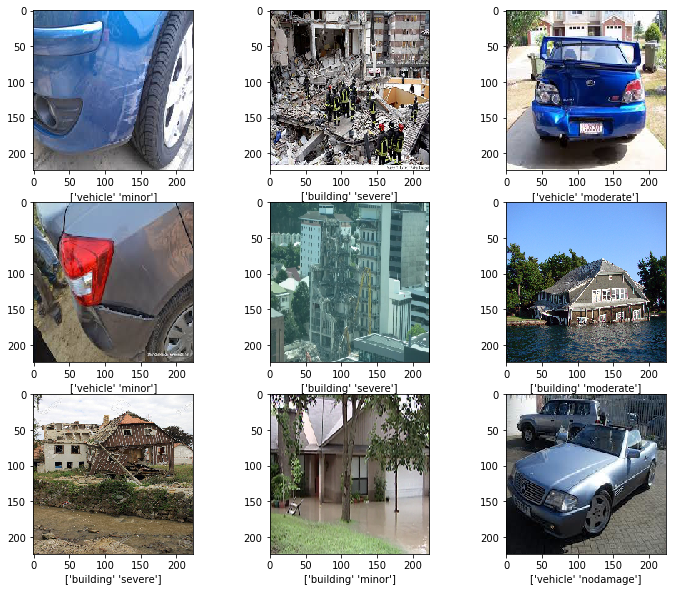

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,10))
for i in range(1,10):
    plt.subplot(3,3,i)
#     plt.imshow(cv2.cvtColor(np.array(data[i] * 255.0, dtype='uint8'), cv2.COLOR_BGR2RGB))
    plt.imshow(data[i])
    plt.xlabel(labels[i])
    plt.grid(False)

### Here’s an example showing how MultiLabelBinarizer  transforms a tuple of ("red", "dress")  to a vector with six total categories

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

labels_example = [
          ("vehicle", "minor"),
          ("vehicle", "moderate"),
          ("vehicle", "severe"),
          ("vehicle", "nodamage"),
          ("building", "minor"),
          ("building", "moderate"),
          ("building", "severe") 
        ]
mlb = MultiLabelBinarizer()
print(mlb.fit(labels_example))`
print(mlb.classes_)
print(mlb.transform([("vehicle", "nodamage")]))

MultiLabelBinarizer(classes=None, sparse_output=False)
['building' 'minor' 'moderate' 'nodamage' 'severe' 'vehicle']
[[0 0 0 1 0 1]]


In order to binarize our labels for multi-class classification, we need to utilize the scikit-learn library’s MultiLabelBinarizer class. You cannot use the standard LabelBinarizer  class for multi-class classification.

In [0]:
# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
 
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

[INFO] class labels:
1. building
2. minor
3. moderate
4. nodamage
5. severe
6. vehicle


### Constructing the training and testing splits as well as initialize the data augmenter

In [0]:
print(len(data))
print(len(labels))

1643
1643


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.2, random_state=42)
 
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
                        height_shift_range=0.1, 
                        shear_range=0.2, 
                        zoom_range=0.2,
                        horizontal_flip=True, 
                        fill_mode="nearest")

In [0]:
train_generator = aug.flow(trainX, trainY, BS)
validation_generator = aug.flow(testX, testY)

### Downloading original inception model

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

inception_model = InceptionV3(weights='imagenet', input_tensor=Input(shape=(IMAGE_DIMS[0],IMAGE_DIMS[1],3)))
# inception_model.save('inception.h5')

96116736/96112376 [==============================] - 27s 0us/step


### Loading the model for training

In [0]:
from keras import backend as K

img_width = IMAGE_DIMS[0]
img_height = IMAGE_DIMS[1]
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMAGE_DIMS[0],IMAGE_DIMS[1],3)))
# base_model = InceptionV3(weights='imagenet', include_top=False)
# base_model.summary()

In [0]:
print(base_model.get_input_shape_at(0))
print(base_model.get_output_shape_at(0))

(None, 224, 224, 3)
(None, 5, 5, 2048)


### Adding a new randomly initialised FC layer using Keras functional API and performing transfer learning

In [0]:
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense

# add a global spatial average pooling layer
x = base_model.get_output_at(0)
x = Flatten(input_shape=base_model.output_shape[1:])(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# this is the model we will train
final_model = Model(inputs=base_model.get_input_at(0), outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
final_model.compile(optimizer='rmsprop', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# train the model on the new data for a few epochs
final_model.fit_generator(
        train_generator,
        epochs=10,
        validation_data=validation_generator)

final_model.save('first_try.h5')  # always save your model after training or during training

Epoch 1/10
42/42 [==============================] - 116s 3s/step - loss: 4.6159 - acc: 0.7010 - val_loss: 4.5703 - val_acc: 0.7158
Epoch 2/10
42/42 [==============================] - 110s 3s/step - loss: 4.2790 - acc: 0.7281 - val_loss: 4.2652 - val_acc: 0.7305
Epoch 3/10
42/42 [==============================] - 109s 3s/step - loss: 3.3384 - acc: 0.7813 - val_loss: 3.0302 - val_acc: 0.8090
Epoch 4/10
42/42 [==============================] - 109s 3s/step - loss: 3.0132 - acc: 0.8010 - val_loss: 2.9475 - val_acc: 0.8110
Epoch 5/10
42/42 [==============================] - 108s 3s/step - loss: 2.8044 - acc: 0.8063 - val_loss: 3.3543 - val_acc: 0.7872
Epoch 6/10
42/42 [==============================] - 108s 3s/step - loss: 2.6908 - acc: 0.8081 - val_loss: 4.0135 - val_acc: 0.7351
Epoch 7/10
42/42 [==============================] - 109s 3s/step - loss: 2.2770 - acc: 0.8230 - val_loss: 1.8053 - val_acc: 0.8313
Epoch 8/10
42/42 [==============================] - 108s 3s/step - loss: 1.0303 - a

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3.
### We will freeze the bottom N layers and train the remaining top layers i.e. (Fine Tuning)

If anyone is interested, I dug up the numbers for Inception v3 as implemented in Keras.

|Inception v3 Block Number|	Layer Number|	Freeze Layers Till|	Number of Trainable Blocks |
|-------------------------|-------------|---------------------|----------------------------|
|0	                      |  40	        |   41	              | 10                         |
|1	                      |  63	        |   64	              | 9                          |
|2	                      |  86	        |   87	              | 8                          |
|3	                      | 100	        |   101	              | 7                          |
|4	                      | 132	        |   133	              | 6                          |
|5	                      | 164	        |   165	              | 5                          |
|6	                      | 196	        |   197	              | 4                          |
|7	                      | 228	        |   229	              | 3                          |
|8	                      | 248	        |   249	              | 2                          |


In [0]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(final_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in final_model.layers[:197]:
    layer.trainable = False
for layer in final_model.layers[197:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy',
              metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
final_model.fit_generator(
        train_generator,
        epochs=20,
        validation_data=validation_generator)
final_model.save('second_try.h5')  # always save your weights after training or during training

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

Epoch 16/20
42/42 [==============================] - 145s 3s/step - loss: 0.3547 - acc: 0.8435 - val_loss: 0.3585 - val_acc: 0.8455
Epoch 17/20
42/42 [==============================] - 142s 3s/step - loss: 0.3526 - acc: 0.8450 - val_loss: 0.3536 - val_acc: 0.8495
Epoch 18/20
42/42 [==============================] - 151s 4s/step - loss: 0.3571 - acc: 0.8415 - val_loss: 0.3442 - val_acc: 0.8516
Epoch 19/20
42/42 [==============================] - 157s 4s/step - loss: 0.3600 - acc: 0.8427 - val_loss: 0.3418 - val_acc: 0.8526
Epoch 20/20
42/42 [==============================] - 155s 4s/step - loss: 0.3517 - acc: 0.8451 - val_loss: 0.3507 - val_acc: 0.8470


### Performing inference using keras model

In [0]:
from keras.models import load_model

model = load_model('second_try.h5')
print(mlb.classes_)

['building' 'minor' 'moderate' 'nodamage' 'severe' 'vehicle']


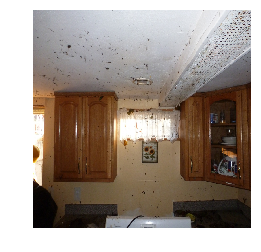

<class 'numpy.ndarray'> (1, 224, 224, 3)
['building', 'minor']


In [0]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
%matplotlib inline

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(IMAGE_DIMS[0], IMAGE_DIMS[1]))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
#     print(type(img_tensor), img_tensor.shape)

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

# image path
img_path = 'Dataset/building_minor/1. hurricane-sandy-flooded-apartment.jpg'      # red, dress

# load a single image
new_image = load_image(img_path, True)
print(type(new_image), new_image.shape)

# check prediction
# pred = model.predict(new_image[:,:,:,::-1]) # Converting image from RGB to BGR
pred = model.predict(new_image)
classes = np.array(mlb.classes_)
filtr = np.vectorize(lambda x : 1 if x > 0.5 else 0)(pred)[0]
print(list(compress(classes, filtr)))

In [0]:
pred

array([[9.9999714e-01, 9.2745739e-01, 4.0715288e-02, 4.7840313e-06,
        1.4935626e-04, 1.2092798e-03]], dtype=float32)

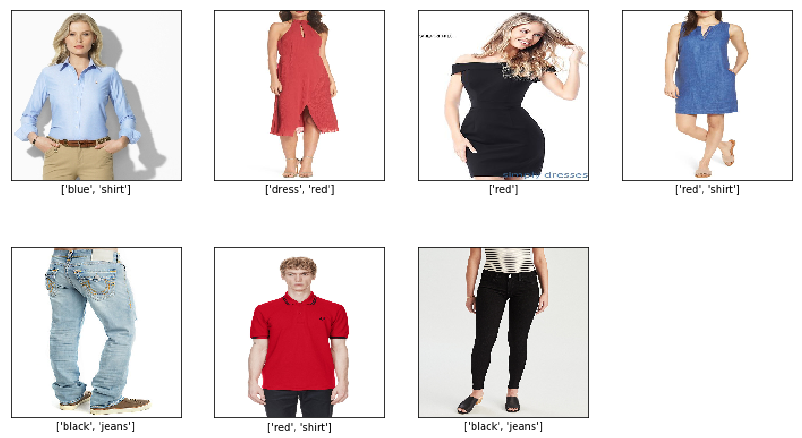

In [0]:
from itertools import compress

PATH = 'keras-multi-label/examples'
examples = os.listdir('keras-multi-label/examples')
classes = np.array(mlb.classes_)
plt.figure(figsize=(14,8))

for i in range(7):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # load a single image
    new_image = load_image(os.path.join(PATH,examples[i]))
    plt.imshow(new_image[0])
    # check prediction
    pred = model.predict(new_image)
    filtr = np.vectorize(lambda x : 1 if x > 0.5 else 0)(pred)[0]
    plt.xlabel('{}'.format(list(compress(classes, filtr))))